# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 3

> *Modelo de Clasificación con CNN para clasificar imágenes en 6 categorías.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [2]:
# Importar desde Google Drive
!pip install -q gdown

In [5]:
# Datasets
import gdown
import zipfile
from pathlib import Path

# Data
import numpy as np

# Visualizaciones
import matplotlib.pyplot as plt
from PIL import Image
import cv2
# from matplotlib.colors import ListedColormap
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
# import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* **buildings**
* **forest**
* **glacier**
* **mountain**
* **sea**
* **street**

Las imágenes están divididas en tres conjuntos:
* **Train**: Alrededor de 14,000 imágenes para entrenamiento.
* **Test**: Alrededor de 3,000 imágenes para evaluación del modelo.
* **Prediction**: Alrededor de 7,000 imágenes para predicción final.

### Descarga

In [6]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=6d78eb2f-9b91-4a68-a964-d2397f6c7919
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:05<00:00, 65.2MB/s]


'TP1-3-natural-scenes.zip'

### Descompresión

In [7]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

### Carga

In [8]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/TP1-3/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test")

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Análisis Exploratorio

In [9]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Conjuntos de Train y Test

Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [11]:
train_ds = train_ds.take(1000)
val_ds = val_ds.take(200)

## Visualizaciones

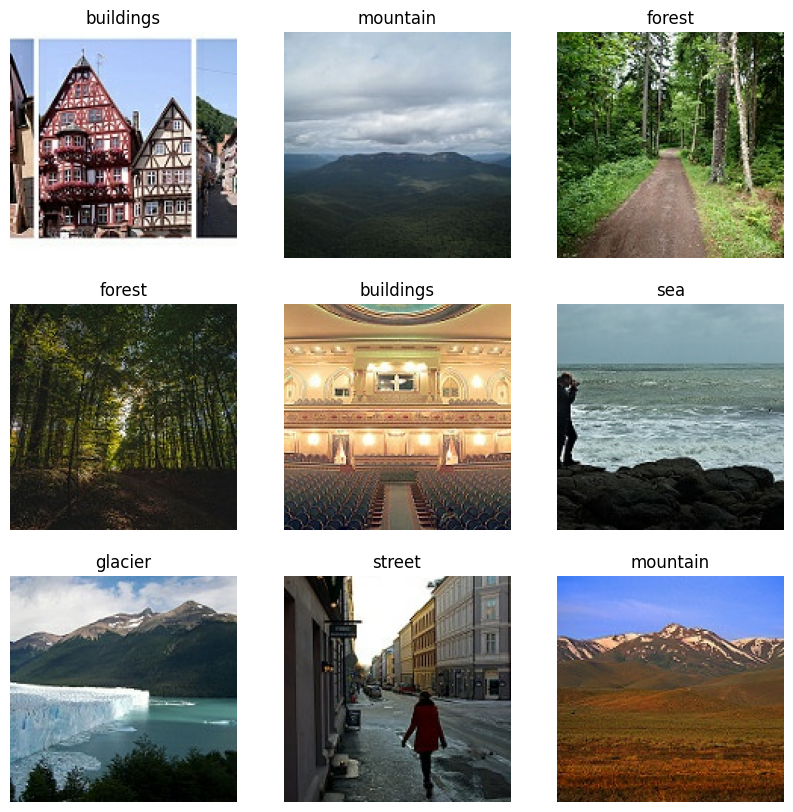

In [12]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Red Neuronal Convolucional

## Modelo

### Definición y entrenamiento

Arquitectura

In [13]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

Construcción

In [14]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


Resumen

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


Entrenamiento

In [16]:
print("Inicio del Entrenamiento")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc, reduce_lr, early_stopping],
)
print("Fin del Entrenamiento")

Inicio del Entrenamiento
Epoch 1/10
200/200 [==============================] - 347s 2s/step - loss: 0.5889 - accuracy: 0.8069 - val_loss: 0.4089 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 376s 2s/step - loss: 0.2878 - accuracy: 0.8969 - val_loss: 0.3808 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 327s 2s/step - loss: 0.2211 - accuracy: 0.9222 - val_loss: 0.3590 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 4/10
200/200 [==============================] - 344s 2s/step - loss: 0.1847 - accuracy: 0.9319 - val_loss: 0.3602 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/10
200/200 [==============================] - 293s 1s/step - loss: 0.1526 - accuracy: 0.9434 - val_loss: 0.3648 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 6/10
200/200 [==============================] - 344s 2s/step - loss: 0.1318 - accuracy: 0.9508 - val_loss: 0.3649 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 7/10
200/200 [===================

### Visualización de Métricas

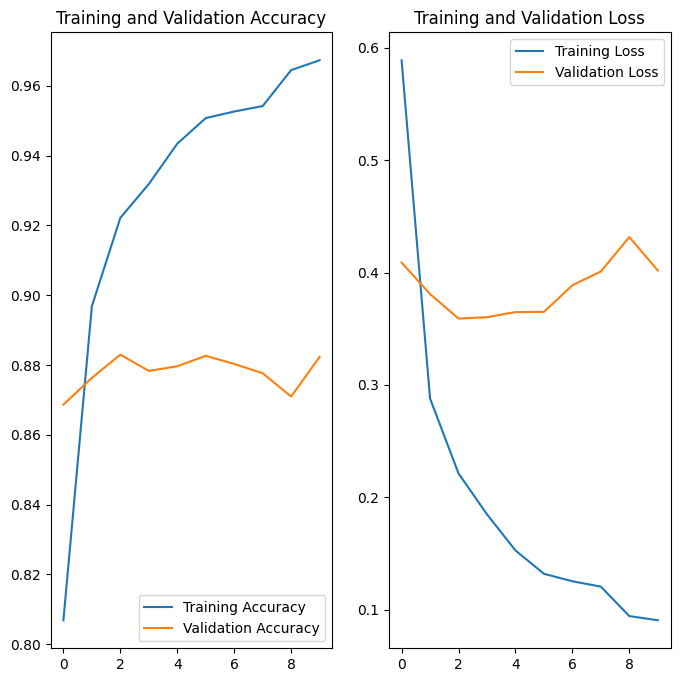

In [17]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicciones